In [26]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [19]:
data_dir = "trafic_32"

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Input shape: torch.Size([8, 3, 32, 32])


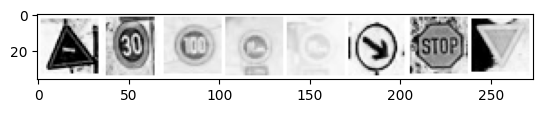

In [24]:
x, y = next(iter(train_loader))
x = x[:8]
print(f"Input shape: {x.shape}")
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

### Diffusion model

In [51]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x*(1 - amount) + noise*amount

In [52]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=1):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64 + time_emb_dim, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, t):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        t = t.view(t.size(0), self.time_emb_dim, 1, 1)
        t = t.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t], dim=1)
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))

        return x

In [53]:
net = BasicUNet().to(device)
net

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(65, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [71]:
n_epochs = 10

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


In [72]:
losses = []

for epoch in range(n_epochs):

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, noise_amount)

        loss = loss_fn(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f"Finished epoch {epoch}, Avg epoch loss: {avg_loss:.5f}")

Finished epoch 0, Avg epoch loss: 0.02002
Finished epoch 1, Avg epoch loss: 0.01917
Finished epoch 2, Avg epoch loss: 0.01881
Finished epoch 3, Avg epoch loss: 0.01864
Finished epoch 4, Avg epoch loss: 0.02030
Finished epoch 5, Avg epoch loss: 0.01908
Finished epoch 6, Avg epoch loss: 0.01917
Finished epoch 7, Avg epoch loss: 0.01873
Finished epoch 8, Avg epoch loss: 0.01838
Finished epoch 9, Avg epoch loss: 0.01833


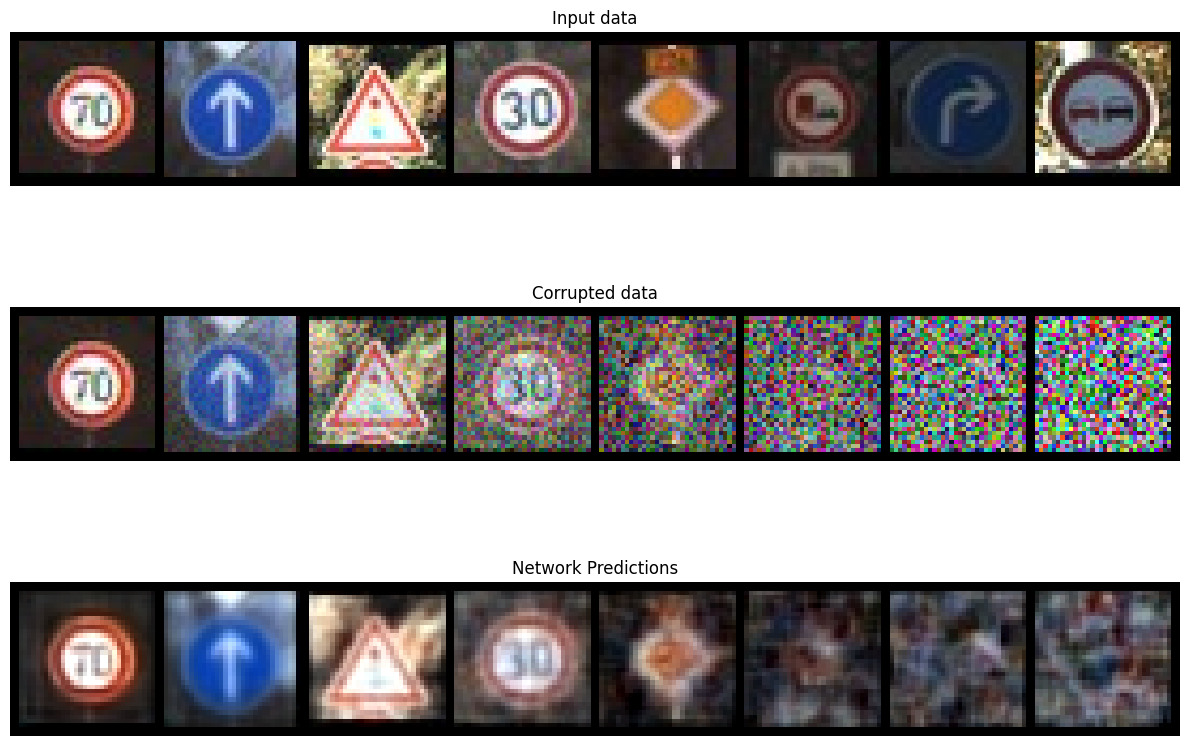

In [76]:
x, y = next(iter(val_loader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device), amount.to(device)).detach().cpu()
 
def show_batch(title, imgs, ax):
    # imgs: Tensor of shape (B, C, H, W)
    grid = torchvision.utils.make_grid(imgs, nrow=imgs.size(0))  # -> (C, H, W)
    grid = grid.permute(1, 2, 0).clip(0, 1).cpu().numpy()          # -> (H, W, C)
    ax.imshow(grid)
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

show_batch("Input data",        x,        axs[0])
show_batch("Corrupted data",    noised_x, axs[1])
show_batch("Network Predictions", preds,  axs[2])

plt.tight_layout()
plt.show()